# 텐서플로우 2.0 버전 선택

In [1]:
# try:
#   %tensorflow_version 2.x
# except Exception:
#   pass

# 텐서플로우 2.0 및 필요한 패키지 import 시키기

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras import datasets, layers, models

print('텐서플로우 버전: {}'.format(tf.__version__))

텐서플로우 버전: 2.2.0


# Pretrained CNN Model 구현하기

텐서플로우에서 제공하는 pretrained model들을 확인해보자

In [ ]:
dir(tf.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

위와 같이 keras에서 imagenet으로 사전 학습된 여러가지 모델들을 확인 할 수 있습니다.  
그 중에서 최신 Image Classification CNN 구조에 영향력이 컷던 VGG, Resnet, Xception, Nasnet을 실습 해 보겠습니다.

## 모델 import 시키기

In [ ]:
# 사용할 pretrained model들을 불러온다
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import NASNetLarge 


# 전처리에 사용할 package들을 불러온다
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## 모델별 특징

들어 가기 앞서 실습에 사용할 각 모델들의 특징을 알아보겠습니다.

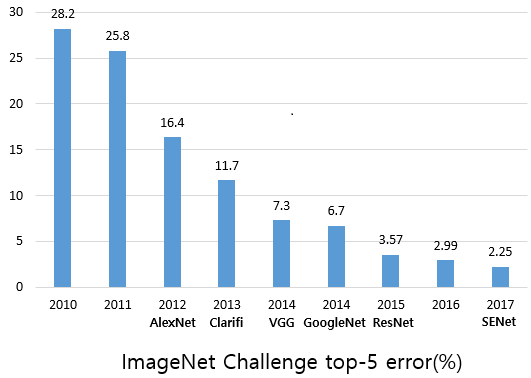

### a. VGG16/19

Oxford 대학의 VGG (Visual Geometry Group)모델은 2012년 Imagenet Challenge를 우승한 alexnet을 개량한 것으로,  
network의 깊이가 모델 성능에 미치는 영향을 연구하였습니다.

똑같은 사이즈의 필터를(3x3) 사용하여, padding size 1로  
convolution layer를 여러번 쌓으며 layer마다 
feature map을 resize 하는것이 아닌,   
max pooling으로 resize 시켜 더 복잡하고 효과적인 feature extraction을 가능토록 하였다고 볼 수 있습니다.  

2014년 imagenet challenge에서 준우승을 하였지만 간결한 구조로 높은 성능을 보인점에서,  
1등이였던 Inception V1 (GoogLenet)보다 더 광범위하게 차용되어,  
VGG 이후 대분의 모델들이 이런 컨셉을 차용하여 매우 큰 영향을 주었다고 볼 수 있습니다.

In [ ]:
model = VGG16(weights="imagenet")
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# 모델의 weight값과 shape이 궁금하다면?
for weights in model.weights:
  print(weights.shape)
  # print(weights)

(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(3, 3, 64, 128)
(128,)
(3, 3, 128, 128)
(128,)
(3, 3, 128, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 256)
(256,)
(3, 3, 256, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(3, 3, 512, 512)
(512,)
(25088, 4096)
(4096,)
(4096, 4096)
(4096,)
(4096, 1000)
(1000,)


### b. ResNet50/101/152

Microsoft사의 Resnet (Residual Nerual Network)은 모델의 깊이가 깊어 질 수록 발생하는 기울기 소실 문제 등을   
Skip Connection 기법과 activation funtion으로 relu를 사용함으로써  
VGG의 16,19 layer보다 더 깊은 152, 1001의 layer를 쌓아 성능을 개선하였습니다.  


Skip Connection의 원리는 layer connection에 일종의 지름길을 만들어 주어  
 역전파의 영향력이 모델의 앞 layer까지 전달 될 수 있도록 함으로써  
 convolution layer 각각의 중요도를 평준화 시켰다고 볼 수 있습니다.  
이러한 컨셉은 최신의 모델들에서 광범위하게 차용되는 것을 확인 할 수 있습니다.

늘어나는 layer 수에 따라 커지는 모델 복잡도를 최적화하기 위해  
max-pooling, hidden fully connected layer, dropout을 사용을 최소화하는 것도 특징입니다. 

In [ ]:
model = ResNet50(weights="imagenet")
model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

### c. Xception

Xcption은 GoogLenet(Inception v1) 모델이 제시한,  
한 layer에서 다른 여러 개 kernel을 사용하여 concat하여  
layer간의 연결을 최소화하는 컨셉을 extreme하게 조정하고   
Resnet의 Skip Connection 기법을 합쳐 더 좋은 성능을 보인 모델입니다.  

GoogLenet과 같이 한 종류의 커널이 아닌 여러가지 커널을 사용하면서  
channel을 분리하여(Separable Convolution layer)  
feature 추출하는 기법을 사용하여 높은 수준의 추상화와 작은 특징도 효율적으로 검출 가능토록 합니다.  


***xcpetion 내용 보충 필요***

In [ ]:
model = Xception(weights="imagenet")
model.summary()

91889664/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

### d. NASNet

NAS(Nerual Architecture Search)란 머신 러닝 설계에 머신 러닝인 AUTOML을 사용하는 연구이며,  
1. feature 추출 방법 최적화 (Automated Feature Learning)  
2. 구조 최적화 (Architecture Search)  
3. 학습률, 배치 사이즈등의 hyperparameter 최적화 (Hyperparameter Optimization)  
이 3가지를 기존의 사람이 아닌, machine에게 맡긴다는 내용입니다.




NASNet은 위의 3가지를 image classification에만 집중한 알고리즘이고
기타 SATA 이미지 분류 모델들에 버금가는 성능을 보여줍니다.

모델 설계를 위해 고려할 parameter가 너무 크다보니 500개의 GPU(NVIDIA P100s GPU)로 4일이라는 긴 학습시간이 소요된다는 아쉬운점이 있지만, 강화 학습 기반으로 사람이 설계한 SATA모델들에 버금가는 성능을 보여준다는것 자체로 큰 의미를 가집니다.

In [ ]:
model = NASNetLarge(weights="imagenet")
model.summary()

359751680/359748576 [==============================] - 4s 0us/step
Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_4[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
__________________________

## 테스트 이미지 파일 업로드

colab 화면의 왼쪽의 파일 경로에 test_images 폴더를 생성 한 후 테스트할 이미지를 업로드 합니다.

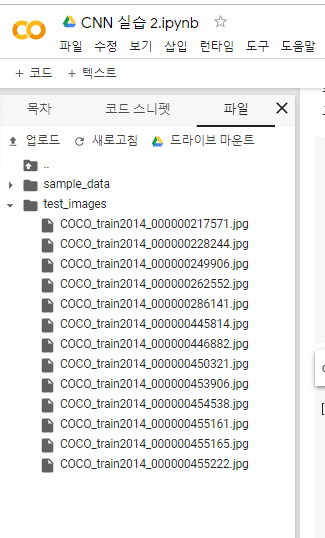

In [ ]:
mkdir test_images # test_images라는 이름의 폴더 생성

In [ ]:
# test 이미지 파일의 경로 설정
# test를 위해 mscoco dataset중 일부 사용
test_images = 'test_images/' # 경로 지정
imagenames = []
for i in os.listdir(test_images):
  if 'jpg' in i:
    imagenames.append(test_images + i)
  else:
    pass

In [ ]:
#test 이미지 리스트
imagenames

['test_images/COCO_train2014_000000446882.jpg',
 'test_images/COCO_train2014_000000217571.jpg',
 'test_images/COCO_train2014_000000286141.jpg',
 'test_images/COCO_train2014_000000262552.jpg',
 'test_images/COCO_train2014_000000249906.jpg',
 'test_images/COCO_train2014_000000453906.jpg',
 'test_images/COCO_train2014_000000454538.jpg',
 'test_images/COCO_train2014_000000228244.jpg',
 'test_images/COCO_train2014_000000455165.jpg',
 'test_images/COCO_train2014_000000445814.jpg',
 'test_images/COCO_train2014_000000455222.jpg',
 'test_images/COCO_train2014_000000455161.jpg',
 'test_images/COCO_train2014_000000450321.jpg']

## 모델 지정 (모델 타입, input shape)

In [ ]:
# 모델 사전을 구축해 불러 온다.
networks = {
  "VGG19": VGG19,
  "ResNet152V2": ResNet152V2,
  "Xception": Xception,
	"NASNetLarge": NASNetLarge
}
# 모델명을 지정한다.
modelname = 'VGG19'

print("Model 로딩 중")
# imagenet으로 사전 학습된 weights를 불러 온다
network = networks[modelname]
model = network(weights="imagenet")

# 각 모델이 사전 학습된 환경에 맞게 input shape와 전처리 함수를 설정해줘야 한다.
# Xception과 inception과 같은 네트워크 사용할시 input shape를 (299x299)로,
# Nasnet은 input shape를 (331,331)로 설정 한다. 

if modelname in ("Xception"):
	input_image_shape = (299, 299)

elif modelname in ("NASNetLarge"):
	input_image_shape = (331, 331)

else:
	input_image_shape = (224, 224)

input_image_preprocess = imagenet_utils.preprocess_input
# 모델 구조 확인
model.summary()

Model 로딩 중
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)  

## 전처리 및 모델 예측

In [ ]:
# test 이미지를 keras tool를 사용하여 사전학습 모델에 
# 알맞은 input shape와 dimension으로 resizing 해준다.
print("이미지 로딩 중")
for i in range(len(imagenames)):
	image = load_img(imagenames[i], target_size=input_image_shape)
	image = img_to_array(image)


	# 위와 같이 test 이미지를 (input_image_shape[0], input_image_shape[1], 3)의 형태인 numpy array로 변환 후
	# conv2d input shape에 맞게 (1, input_image_shape[0], input_image_shape[1], 3)로 dimension을 늘려준다.
	image = np.expand_dims(image, axis=0)

	# 로드된 각 모델에 맞게 전처리를 해준다 (mean subtraction, scaling, 등을 pretrained 되었던 전처리 방법과 동일하게 함.)
	# 비교적 최신 모델들은 tensorflow를 사용하였고 그전 모델들은 caffe framework를 사용하였다.
	if modelname in ("Xception", "NASNetLarge", "InceptionResNetV2", "ResNet152V2"):
		image = input_image_preprocess(image, mode='tf')
		print('전처리 mode: tf')
 
	else:
		image = input_image_preprocess(image, mode='caffe')
		print('전처리 mode: caffe')

	# predict된 integer 값을 decoding하여 이미지 분류값 표시
	print("{} 예측값:".format(modelname))
	preds = model.predict(image)
	prediction = imagenet_utils.decode_predictions(preds)

	# top5 예측값과 그에 해당하는 확률값을 불러온다
	for (top, (imagenetID, yhat, confidence)) in enumerate(prediction[0]):
		print("{}. {}: {:.2f}%".format(top + 1, yhat, confidence * 100))
	
	# top1
	(imagenetID, yhat, confidence) = prediction[0][0]

	# OpenCV를 통해 test 이미지를 load,

	# colab 버전의 OpenCV를 통해 화면에 표시한다.
	img = cv2.imread(imagenames[i])
	

	# top prediction을 이미지에 추가
	# 왼쪽 위부터 text 시작 좌표(5, 30), font 설정, font scale, 눈에 잘 띄는 빨강색으로 설정 (B, G, R), text 선 굵기
	cv2.putText(img, "prediction: {} - {:.2f}%".format(yhat, confidence * 100),	
	            (5, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2) 
	cv2_imshow(cv2.resize(img, (400, 300)))
	cv2.waitKey(0)

Output hidden; open in https://colab.research.google.com to view.

## Q1. ResNet152, Xception, NASNetLarge 으로 model을 변경하여 결과를 비교해보세요.

### A. modelname 변경

In [ ]:
networks = {
  "VGG19": VGG19,
  "ResNet152": ResNet152,
  "Xception": Xception,
	"NASNetLarge": NASNetLarge
}
modelname = 'ResNet152'

print("Model 로딩 중")
network = networks[modelname]
model = network(weights="imagenet")

if modelname in ("Xception"):
	input_image_shape = (299, 299)

elif modelname in ("NASNetLarge"):
	input_image_shape = (331, 331)

else:
	input_image_shape = (224, 224)

input_image_preprocess = imagenet_utils.preprocess_input

print("이미지 로딩 중")
for i in range(len(imagenames)):
	image = load_img(imagenames[i], target_size=input_image_shape)
	image = img_to_array(image)
	image = np.expand_dims(image, axis=0)

	if modelname in ("Xception", "NASNetLarge", "ResNet152V2"):
		image = input_image_preprocess(image, mode='tf')
		print('전처리 mode: tf')
 
	else:
		image = input_image_preprocess(image, mode='caffe')
		print('전처리 mode: caffe')

	print("{} 예측값:".format(modelname))
	preds = model.predict(image)
	prediction = imagenet_utils.decode_predictions(preds)

	for (top, (imagenetID, yhat, prob)) in enumerate(prediction[0]):
		print("{}. {}: {:.2f}%".format(top + 1, yhat, prob * 100))

	img = cv2.imread(imagenames[i])
	(imagenetID, yhat, prob) = prediction[0][0]
	cv2.putText(img, "prediction: {}, {:.2f}%".format(yhat, prob * 100),
		(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
	cv2_imshow(cv2.resize(img, (400, 300)))
	cv2.waitKey(0)

In [ ]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Q2. Densenet201, InceptionV3 모델을 import 하여 결과를 비교 해보세요.

### A. model의 input shape, framework를 확인하여 모델에 맞게 설정 필요.

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import InceptionV3

In [ ]:
networks = {
  "DenseNet201": DenseNet201,
  "InceptionV3": InceptionV3,
}
modelname = 'InceptionV3'

print("Model 로딩 중")
network = InceptionV3
model = network(weights="imagenet")

if modelname in ("Xception", "InceptionV3"):
	input_image_shape = (299, 299)

elif modelname in ("NASNetLarge"):
	input_image_shape = (331, 331)

else:
	input_image_shape = (224, 224)

input_image_preprocess = imagenet_utils.preprocess_input

model.summary()



print("이미지 로딩 중")
for i in range(len(imagenames)):
	image = load_img(imagenames[i], target_size=input_image_shape)
	image = img_to_array(image)
	image = np.expand_dims(image, axis=0)

	if modelname in ("InceptionV3", "DenseNet201"):
		image = input_image_preprocess(image, mode='tf')
		print('전처리 mode: tf')
 
	else:
		image = input_image_preprocess(image, mode='caffe')
		print('전처리 mode: caffe')

	print("{} 예측값:".format(modelname))
	preds = model.predict(image)
	prediction = imagenet_utils.decode_predictions(preds)

	for (top, (imagenetID, yhat, prob)) in enumerate(prediction[0]):
		print("{}. {}: {:.2f}%".format(top + 1, yhat, prob * 100))

	img = cv2.imread(imagenames[i])
	(imagenetID, yhat, prob) = prediction[0][0]
	cv2.putText(img, "prediction: {}, {:.2f}%".format(yhat, prob * 100),
		(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
	cv2_imshow(cv2.resize(img, (400, 300)))
	cv2.waitKey(0)

Model 로딩 중
96116736/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 149, 149, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 149, 149, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_260 (Activation)     (None, 149, 149, 32) 0           batch_normalization_4[0][0]      
___________

FileNotFoundError: ignored